In [68]:
%matplotlib inline
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./test.csv
./submission.csv
./titanic_survived_by_class.pdf
./random_forest_approach.ipynb
./train.csv
./titanic_survived_heatmap_sex_class.pdf
./titanic_survived_by_dock.pdf
./gender_submission.csv
./titanic_survived_by_sex.pdf
./Neural_netwok_approach.ipynb
./titanic_survived_by_title.pdf
./titanic_survived_by_relatives.pdf


# 1) Understanding the Data

In [4]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
print(f"The dimensions of the training set are {train_data.shape}")
print(f"The dimensions of the test set are {test_data.shape}")
train_data.head()

The dimensions of the training set are (891, 12)
The dimensions of the test set are (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

In [9]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,29.599282,0.447368,0.392344,35.627188
std,120.810458,0.841838,12.703770,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,23.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,35.750000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [11]:
train_data.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
test_data.isnull().sum()


PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [13]:
test_data['Fare'].fillna(test_data.Fare.mean(), inplace=True)

# 1.1) Does sex affect the chace of survival?

In [14]:
def survival_rate_by_category(df, feature):
    category = df[str(feature)].unique()
    for i in category:
        survival = df[df[str(feature)]==i].Survived.sum()/len(df[df[str(feature)]==i])
        print(f"Propotion of {feature} = {i} survived is {survival}")

In [15]:
survival_rate_by_category(train_data, 'Sex')

Propotion of Sex = male survived is 0.18890814558058924
Propotion of Sex = female survived is 0.7420382165605095


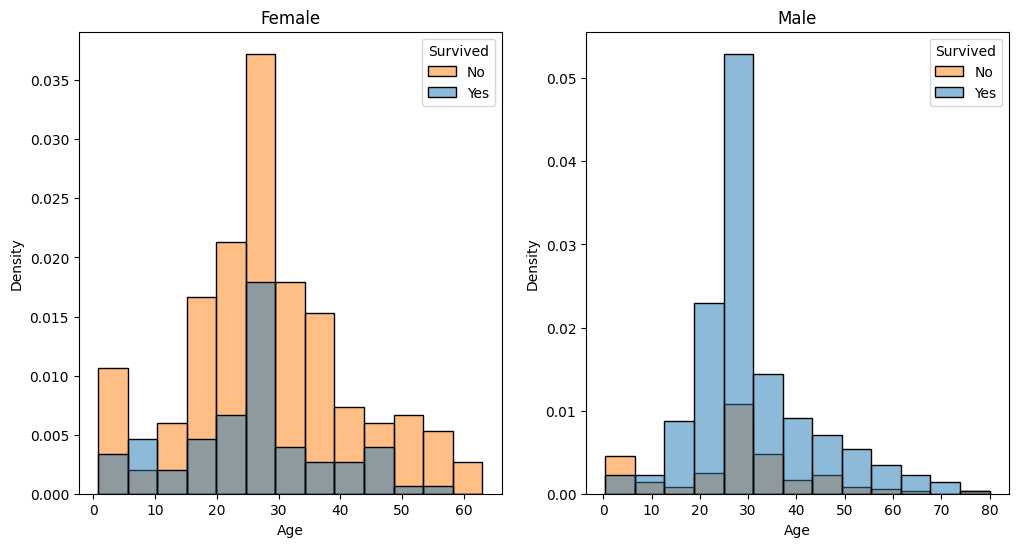

In [16]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
sns.histplot(data=train_data[train_data['Sex']=='female'], x='Age', hue='Survived', stat = 'density', bins=13, ax=axes[0])
sns.histplot(data=train_data[train_data['Sex']=='male'], x='Age', hue='Survived', stat = 'density', bins=13,  ax=axes[1])
sex = ['Female','Male']
for ax, s in zip(axes,sex):
    ax.legend(title='Survived', labels=['No', 'Yes'])
    ax.set_title(f'{s}')
#fig.savefig('titanic_survived_by_sex.pdf')

# 1.2) Does ticket class affect the chace of survival?

In [17]:
survival_rate_by_category(train_data,'Pclass')

Propotion of Pclass = 3 survived is 0.24236252545824846
Propotion of Pclass = 1 survived is 0.6296296296296297
Propotion of Pclass = 2 survived is 0.47282608695652173


/tmp/ipykernel_173464/1884320002.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(x='Pclass', y='Survived', data=train_data, ci=68, hue='Sex')


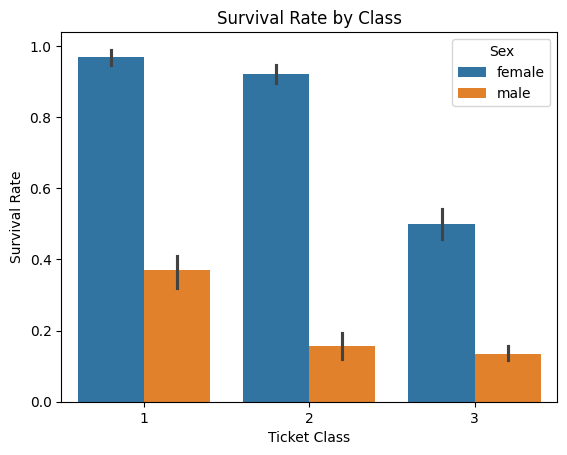

In [18]:
plt.cla()
# show only 1-sigma for the survival rate
sns.barplot(x='Pclass', y='Survived', data=train_data, ci=68, hue='Sex')
plt.title('Survival Rate by Class')
plt.xlabel('Ticket Class')
plt.ylabel('Survival Rate');
#plt.savefig('titanic_survived_by_class.pdf')

# 1.3) The data suggests that women survived at a higher rate. Does being a female in first class increase your chances of survival?

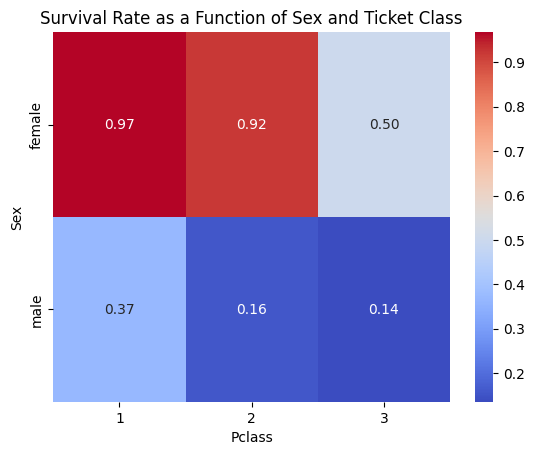

In [19]:
pivot_table = pd.pivot_table(train_data, values='Survived', index='Sex', columns='Pclass', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.2f', cbar=True);
plt.title('Survival Rate as a Function of Sex and Ticket Class')
#plt.savefig('titanic_survived_heatmap_sex_class.pdf')

- We can use this as an engineered feature since there is strong correlation!
- Will add it to the test set as well to match the dimensions

In [20]:
train_data['Adjusted_survival'] = train_data.apply(lambda row: pivot_table.loc[row['Sex'],row['Pclass']],axis=1)
test_data['Adjusted_survival'] = test_data.apply(lambda row: pivot_table.loc[row['Sex'],row['Pclass']],axis=1)

# 1.4) What about titles? Does the chance of survival depend on whether you're a common man or a major?

In [21]:
train_data['Title'] = train_data['Name'].str.extract(r'(\w+)(?=\.)')
test_data['Title'] = test_data['Name'].str.extract(r'(\w+)(?=\.)')
train_data.Title.value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

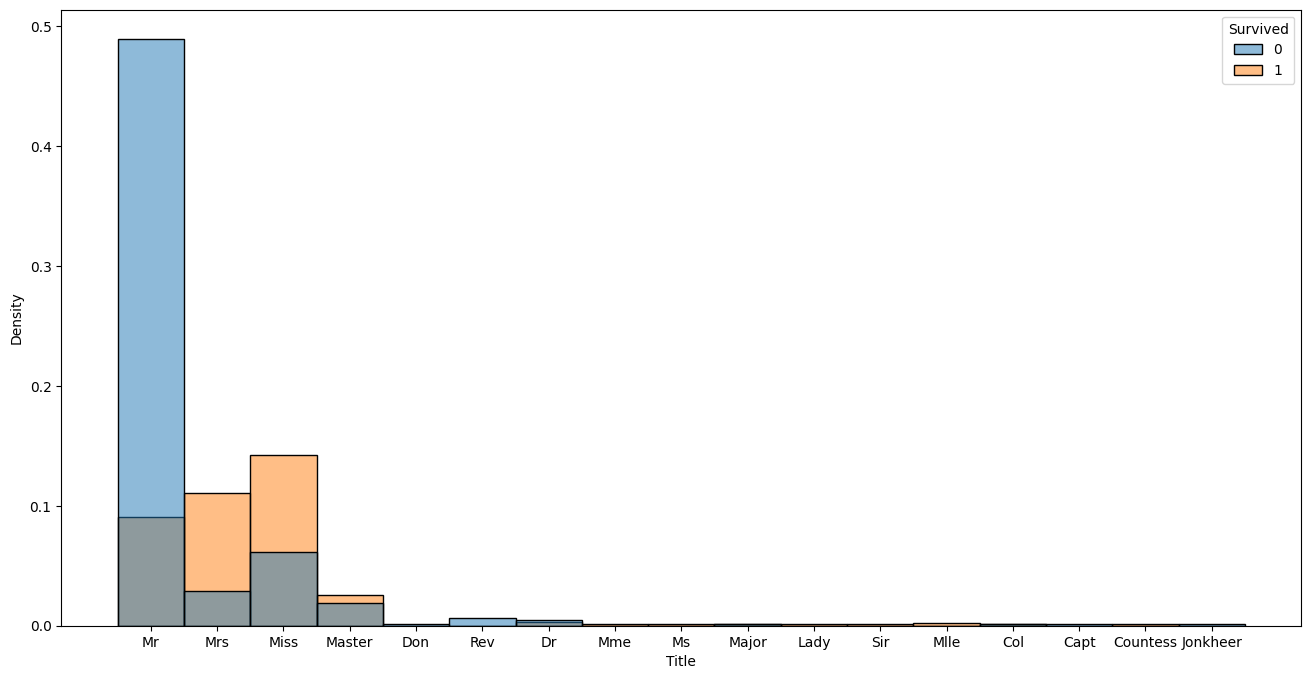

In [22]:
plt.figure(figsize=(16,8))
sns.histplot(data=train_data, x='Title', hue='Survived', stat = 'density', bins=13)
#plt.savefig('titanic_survived_by_title.pdf')

- Miss hass the higher chance of survival but we already knew that more women survived. We can ignore the title as a feature.

In [23]:
train_data.drop(columns=['Title'],axis=1,inplace=True)
test_data.drop(columns=['Title'],axis=1,inplace=True)

# 1.5) Does Embarked affect the survival rate? 


In [24]:
train_data.Embarked.info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Embarked
Non-Null Count  Dtype 
--------------  ----- 
889 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [25]:
common_value = train_data.Embarked.value_counts().sort_values(ascending=False).index[0]
train_data.Embarked.fillna(common_value, inplace=True)
train_data.Embarked.isnull().sum()

0

/tmp/ipykernel_173464/2433055351.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(x='Embarked', y='Survived', data=train_data, ci=68, hue='Sex')


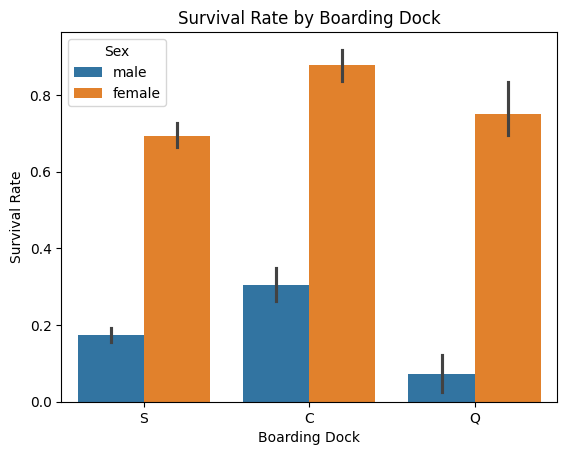

In [26]:
sns.barplot(x='Embarked', y='Survived', data=train_data, ci=68, hue='Sex')
plt.title('Survival Rate by Boarding Dock')
plt.xlabel('Boarding Dock')
plt.ylabel('Survival Rate');
#plt.savefig('titanic_survived_by_dock.pdf')

- it makes a bit of a difference: let's add it as a feature.

# 1.6) What about family?
- SibSp: number of siblings and/or spouses 
- Parch: number of parents/children aboard the Titanic

In [27]:
# let's add a column for family = SibSp + Parch
train_data['Family'] = train_data['SibSp'] + train_data['Parch']
test_data['Family'] = test_data['SibSp'] + test_data['Parch']

In [28]:
survival_rate_by_category(train_data,'SibSp')

Propotion of SibSp = 1 survived is 0.5358851674641149
Propotion of SibSp = 0 survived is 0.34539473684210525
Propotion of SibSp = 3 survived is 0.25
Propotion of SibSp = 4 survived is 0.16666666666666666
Propotion of SibSp = 2 survived is 0.4642857142857143
Propotion of SibSp = 5 survived is 0.0
Propotion of SibSp = 8 survived is 0.0


In [29]:
survival_rate_by_category(train_data,'Parch')

Propotion of Parch = 0 survived is 0.34365781710914456
Propotion of Parch = 1 survived is 0.5508474576271186
Propotion of Parch = 2 survived is 0.5
Propotion of Parch = 5 survived is 0.2
Propotion of Parch = 3 survived is 0.6
Propotion of Parch = 4 survived is 0.0
Propotion of Parch = 6 survived is 0.0


In [30]:
survival_rate_by_category(train_data,'Family')

Propotion of Family = 1 survived is 0.5527950310559007
Propotion of Family = 0 survived is 0.30353817504655495
Propotion of Family = 4 survived is 0.2
Propotion of Family = 2 survived is 0.5784313725490197
Propotion of Family = 6 survived is 0.3333333333333333
Propotion of Family = 5 survived is 0.13636363636363635
Propotion of Family = 3 survived is 0.7241379310344828
Propotion of Family = 7 survived is 0.0
Propotion of Family = 10 survived is 0.0


/tmp/ipykernel_173464/3112939700.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(data=train_data, x='Family', y='Survived', hue='Sex', ci=68);


Text(0.5, 1.0, 'Survival Rate as a Function of Sex and Ticket Class')

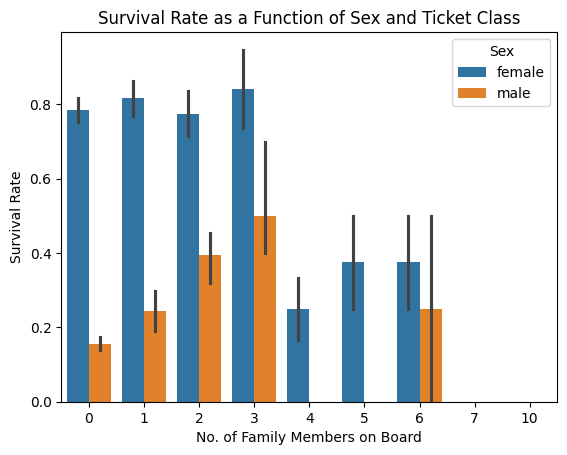

In [31]:
sns.barplot(data=train_data, x='Family', y='Survived', hue='Sex', ci=68);
plt.xlabel('No. of Family Members on Board')
plt.ylabel('Survival Rate')
plt.title('Survival Rate as a Function of Sex and Ticket Class')


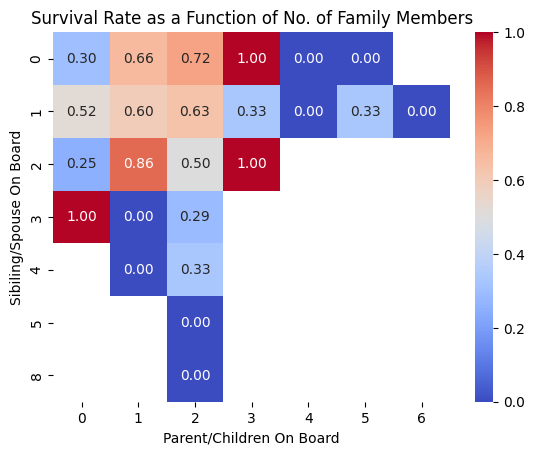

In [32]:
pivot_table_family = pd.pivot_table(train_data, values='Survived', index='SibSp', columns='Parch', aggfunc='mean')
sns.heatmap(pivot_table_family, annot=True, cmap='coolwarm', fmt='.2f', cbar=True);
plt.xlabel('Parent/Children On Board')
plt.ylabel('Sibiling/Spouse On Board')
plt.title('Survival Rate as a Function of No. of Family Members')
#plt.savefig('titanic_survived_by_relatives.pdf')

- This info palces strong constrains on the data. 
- Given that Family is degenerat with SibSp and Parch, we will only add Family.

In [33]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Adjusted_survival,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.135447,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.968085,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.500000,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.968085,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.135447,0


# Before moving forward, let's check the test data compatibilty with these new features

In [34]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        418 non-null    int64  
 1   Pclass             418 non-null    int64  
 2   Name               418 non-null    object 
 3   Sex                418 non-null    object 
 4   Age                418 non-null    float64
 5   SibSp              418 non-null    int64  
 6   Parch              418 non-null    int64  
 7   Ticket             418 non-null    object 
 8   Fare               418 non-null    float64
 9   Cabin              91 non-null     object 
 10  Embarked           418 non-null    object 
 11  Adjusted_survival  418 non-null    float64
 12  Family             418 non-null    int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 42.6+ KB


In [35]:
test_data.isnull().sum()

PassengerId            0
Pclass                 0
Name                   0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                327
Embarked               0
Adjusted_survival      0
Family                 0
dtype: int64

In [36]:
test_data.Fare.fillna(test_data.Fare.mean(), inplace=True)

In [37]:
train_data.isnull().sum()

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
Embarked               0
Adjusted_survival      0
Family                 0
dtype: int64

In [38]:
[i for i in train_data.columns.tolist() if i!= 'Survived'] == test_data.columns.tolist()


True

In [39]:
train_data.columns.tolist()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Adjusted_survival',
 'Family']

In [40]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Adjusted_survival,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.135447,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.968085,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.500000,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.968085,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.135447,0


# 2) Feature Selection

- Age, Fare, Pclass as is
- Hot-encoded: Sex, Embarked
- Engineered: 1) Family. 2) Adjusted_survival based on correlation between Pclass and Age

Age, Fare, Sex (hot-encoded value), Engineered Title (hot-encoded value), Pclass, Sibsp, Parch 

In [41]:
#reinitialize the frames
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

# drop irrelevant columns
def drop_col_feature_eng_separate_target(df):
    # change index
    df.set_index('PassengerId',inplace=True)
    df['Adjusted_survival'] = df.apply(lambda row: pivot_table.loc[row['Sex'],row['Pclass']],axis=1)
    df['Family'] = df['SibSp'] + df['Parch']
    df['Age'].fillna(df['Age'].median(), inplace=True)

    # drop some irrelevant features
    df.drop(['Ticket', 'Cabin','SibSp','Parch', 'Name'], axis=1, inplace=True)
    # hot encode Sex and Embarked. Family & Adjusted-Survival have been added already
    df_new = pd.get_dummies(df, columns=['Sex', 'Embarked'],dtype=int)
    
    
    features = [i for i in df_new.columns.tolist() if i!= 'Survived']
    X = df_new[features]
    if 'Survived' in df.columns:
        Y = df_new['Survived']
    else:
        Y = None
    return X, Y, features

X_train_clean, y_train_clean, features = drop_col_feature_eng_separate_target(train_data)
X_test_clean, _, _ = drop_col_feature_eng_separate_target(test_data)

In [42]:
X_train_clean.columns.tolist()

['Pclass',
 'Age',
 'Fare',
 'Adjusted_survival',
 'Family',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [43]:
X_test_clean.columns.tolist()

['Pclass',
 'Age',
 'Fare',
 'Adjusted_survival',
 'Family',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [44]:
X_train_clean

,Pclass,Age,Fare,Adjusted_survival,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,3,22.0,7.2500,0.135447,1,0,1,0,0,1
2,1,38.0,71.2833,0.968085,1,1,0,1,0,0
3,3,26.0,7.9250,0.500000,0,1,0,0,0,1
4,1,35.0,53.1000,0.968085,1,1,0,0,0,1
5,3,35.0,8.0500,0.135447,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
887,2,27.0,13.0000,0.157407,0,0,1,0,0,1
888,1,19.0,30.0000,0.968085,0,1,0,0,0,1
889,3,28.0,23.4500,0.500000,3,1,0,0,0,1


In [45]:
RAND_STAT = 10
X_train, X_cv, y_train, y_cv = train_test_split(X_train_clean, y_train_clean, train_size = 0.8, random_state = RAND_STAT)


In [46]:
print(f'train samples: {len(X_train)}\ntest samples: {len(X_cv)}')


train samples: 712
test samples: 179


In [47]:
X_train.isnull().sum()

Pclass               0
Age                  0
Fare                 0
Adjusted_survival    0
Family               0
Sex_female           0
Sex_male             0
Embarked_C           0
Embarked_Q           0
Embarked_S           0
dtype: int64

# 3) Models
- Let's test different Models: RandomForestClassifier, DecisionTreeClassifier, and XGBoost

# 3.1) Random Forest with Hyperparameter tuning

In [53]:
# dictionary to keep track of accuracies
results = {}

In [66]:
# Hyperparameter tuning with RandomForest
param_grid = {
    'max_depth': [ 3, 4, 5, 6, 7, 8, 10,15, 20, 30],
    'min_samples_split': [5, 10, 20, 30, 40, 50, 60, 80, 90, 100]
}

# Create a RandomForestClassifier instance
RF = RandomForestClassifier(random_state = RAND_STAT)

# Create the GridSearchCV instance
grid_search_RF = GridSearchCV(estimator=RF, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model
grid_search_RF.fit(X_train, y_train)
# Get the best parameters
best_params_RF = grid_search_RF.best_params_

# How does it perform on the train and cv data?
RF_train_acc = grid_search_RF.score(X_train, y_train)
RF_cv_acc = grid_search_RF.score(X_cv, y_cv)

# Store in a dictionary
results['RandomForest'] = {'Training Accuracy': RF_train_acc, 'CV Accuracy': RF_cv_acc, 'Best Params': best_params_RF}
print(results['RandomForest'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ...................max_depth=3, min_samples_split=5; total time=   0.2s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   0.2s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   0.2s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   0.2s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   0.3s[CV] END ..................max_depth=3, min_samples_split=10; total time=   0.3s

[CV] END ..................max_depth=3, min_samples_split=10; total time=   0.3s
[CV] END ..................max_depth=3, min_samples_split=10; total time=   0.4s
[CV] END ..................max_depth=3, min_samples_split=20; total time=   0.2s
[CV] END ..................max_depth=3, min_samples_split=20; total time=   0.2s
[CV] END ..................max_depth=3, min_samples_split=10; total time=   0.4s
[CV] END ..................max_depth=3, min_sa

# 3.2) DecisionTree Classifier with hyperparameter tuning

In [71]:
# Create a DecisionTreeClassifier instance
DecisionTree = DecisionTreeClassifier(random_state = RAND_STAT)
grid_search_DT = GridSearchCV(estimator=DecisionTree, param_grid=param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
# Fit the model
grid_search_DT.fit(X_train, y_train)

# Get the best parameters
best_params_DT = grid_search_DT.best_params_

# Performance of the model
DT_train_acc = grid_search_DT.score(X_train, y_train)
DT_cv_acc = grid_search_DT.score(X_cv, y_cv)

# store metrics in the dictionary and print
results['DecisionTrees'] = {'Training Accuracy': DT_train_acc, 'CV Accuracy': DT_cv_acc, 'Best Params': best_params_DT}
print(results['DecisionTrees'])


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ...................max_depth=3, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=3, min_samples_split=10; total time=   0.0s
[CV] END ..................max_depth=3, min_samples_split=10; total time=   0.0s
[CV] END ..................max_depth=3, min_samples_split=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=3, min_samples_split=20; total time=   0.0s
[CV] END ..................max_depth=3, min_samples_split=20; total time=   0.0s
[CV] END ..................max_depth=3, min_samples_split=20; total time=   0.0s
[CV] END ..................max_depth=3, min_samples_split=20; total time=   0.0s
[CV] END ..................max_depth=3, min_sa

# 3.3) XGBoost with Hyperparameter tuning

In [72]:
param_grid_XGB = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 10,15, 20, 30],
    'n_estimators': [50, 100, 150, 200, 350]
}

# XGBoost instance
XGBoost = xgb.XGBClassifier(random_state = RAND_STAT, use_label_encoder=False, eval_metric='logloss')
grid_search_XGB = GridSearchCV(estimator=XGBoost, param_grid=param_grid_XGB, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the mode
grid_search_XGB.fit(X_train,y_train)
# Get the best parameters
best_params_XGB = grid_search_XGB.best_params_

# Performance of the model
XGB_train_acc = grid_search_XGB.score(X_train, y_train)
XGB_cv_acc = grid_search_XGB.score(X_cv, y_cv)

# store metrics in the dictionary and print
results['XGBoost'] = {'Training Accuracy': XGB_train_acc, 'CV Accuracy': XGB_cv_acc, 'Best Params': best_params_XGB}
print(results['XGBoost'])


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=150; total time=   0.1s
[CV] END .learning_rate=0.001, max_depth=3, n

In [84]:
#Rank the model performance on training / cv  Data

# Sort the models based on 'Training Accuracy'
sorted_results = sorted(results.items(), key=lambda x: x[1]['Training Accuracy'], reverse=True)

# Print the sorted models with their Training Accuracy
print("Ranking of accuracy on training set")
for i, (model, model_results) in enumerate(sorted_results):
    print(f"{i+1}) {model}: {round(model_results['Training Accuracy'], 2)}")

# Sort the models based on 'cv Accuracy'
sorted_results = sorted(results.items(), key=lambda x: x[1]['CV Accuracy'], reverse=True)

# Print the sorted models with their Training Accuracy
print("\nRanking of accuracy on cross-validation set")
for i, (model, model_results) in enumerate(sorted_results):
    print(f"{i+1}) {model}: {round(model_results['CV Accuracy'], 2)}")

Ranking of accuracy on training set
1) RandomForest: 0.87
2) XGBoost: 0.86
3) DecisionTrees: 0.83

Ranking of accuracy on cross-validation set
1) XGBoost: 0.85
2) RandomForest: 0.84
3) DecisionTrees: 0.83


# 4) Inference

- Import the test dataset
- Process it in the same way
- Carry out inference

In [74]:
test_data = pd.read_csv('./test.csv')

In [75]:
# clean the data
X_test, y_test, features = drop_col_feature_eng_separate_target(test_data)
X_test['Fare'].fillna(X_test['Fare'].median(), inplace=True)

In [76]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pclass             418 non-null    int64  
 1   Age                418 non-null    float64
 2   Fare               418 non-null    float64
 3   Adjusted_survival  418 non-null    float64
 4   Family             418 non-null    int64  
 5   Sex_female         418 non-null    int64  
 6   Sex_male           418 non-null    int64  
 7   Embarked_C         418 non-null    int64  
 8   Embarked_Q         418 non-null    int64  
 9   Embarked_S         418 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 35.9 KB


In [78]:
X_test.isnull().sum()

Pclass               0
Age                  0
Fare                 0
Adjusted_survival    0
Family               0
Sex_female           0
Sex_male             0
Embarked_C           0
Embarked_Q           0
Embarked_S           0
dtype: int64

- Since XGBoost had the highest score on CV dataset, we use it for inference.

In [93]:
predictions = grid_search_XGB.predict(X_test)

In [94]:
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': predictions})
output.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [95]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
